# Time Series Analysis II

| $\text{Type}$     | $\text{Maturity}$                        |
| ----------------- | ---------------------------------------- |
| $\text{Bill (b)}$ | $1\text{m} \leq \text{T} \leq 1\text{Y}$ |
| $\text{Note (N)}$ | $1\text{Y} \lt \text{T} \lt 10\text{Y}$  |
| $\text{Bond (B)}$ | $\quad\quad\ \ \text{T} \geq 10\text{Y}$ |

## What is a Constant Maturity Treasury?

According to [Investopedia](https://www.investopedia.com/terms/c/constantmaturity.asp), Constant Maturity is an adjustment for equivalent maturity, used by the Federal Reserve Board to compute an index based on the average yield of various Treasury securities maturing at different periods.

One would use constant maturity yields as reference for pricing all kinds of depts or fixed income securities, fixed income securities being by far the largest type of security in U.S. Securities markets.

## Nominal Yield Curve Rates vs. Real Yield Curve Rates

According to the Board of Governors of the Federal Reserve System, a [nominal Treasury security](https://www.federalreserve.gov/data/nominal-yield-curve.htm) is an issuance that specifies principal and interest as fixed dollar amounts to the holder. Since Treasury securities are backed by the full faith and credit of the U.S. government, the returns investors can earn on them are often used as a “risk-free” benchmark in finance research and investment practice. These securities are a promise to repay the principal (with interest if a note or a bond) to the holder (can be a public or private entity). Therefore, the real yield curve rate would be adjusted for inflation in the yield curve.

## Statement of Purpose

The purpose of this time series analysis is to work the "next steps" highlighted under `Treas TS Analysis I`. These steps are as follows:

1. Time-Series Forecasting
2. Cross-Validation and Testing on New Data
3. Vector Autoregressive Fractional Integrated Moving Average
4. Markov Chain Monte Carlo
5. Heteroscedastic Models
6. Fourier Analysis and Spectral Analysis

The first step subsequent to the analysis in `Treas TS Analysis I` is to do forecasting. I would need to define the "event horizon", how many steps I can take beyond the event horizon and what is the prediction error. Hopefully, I have better forecasts than what I obtained in `Treas Exploratory Analysis` using a "top down" approach.

The second step is done to avoid "over-fitting" (more regressors than observations) or "under-fitting" (more observations than regressors) the data. For time series, regressors, also known as "explanatory variables", are the lagged W values I found earlier, under `Treas TS Analysis I`. There are other variables beyond the scope of the R-CMT and N-CMT rates explored in these notebooks, such as price of any specific security (reminder that these prices are based on an index of the average yield, meaning that they are not based on the price of any particular security present in the market at the time), the average strike placed by investors, the average per capita savings, the per capita debt, the Gross National Product of the USA, &c.

The third step goes beyond ARIMA, exploring VARFIMA models. I will be making subsequent forecasts with these varfima models, making cross-validations where adequate.

The fourth step tests both the basic ARIMA models and the VARFIMA models using the MCMC method. This is a durability test for any univariate, bivariate or multivariate distribution. Realistically, it is the posterior distribution what is being tested using the MCMC method, meaning "after the fact", after taking into account all relevant evidence or background on the particular data being examined or analyzed.

## Loading Packages and Initializing Module / Importing Libraries

In [1]:
using CSV, DataFrames, Distributions, HypothesisTests
using LinearAlgebra, MCMCChains, Plots
using Random, Serialization, StatsBase, StatsPlots, Turing

In [6]:
tnf = CSV.read("log_diff.csv", DataFrame)

,x5,x7,x10,x20,x30
,Float64,Float64,Float64,Float64,Float64
1,-0.000728628,-0.0117053,-0.00803528,-0.00687697,-0.00475442
2,0.0576037,0.0546078,0.0424119,0.0209846,0.0182711
3,0.0208363,0.0207428,0.0111017,0.0134675,0.00191849
4,0.0314214,0.0201543,0.0233585,0.024437,0.0210536
5,0.00767738,0.0151621,0.0067988,-0.000791054,0.00985471
6,-0.0148034,-0.0145158,-0.00974972,-0.00501027,-0.00491387
7,0.00630865,0.0110279,0.00970655,0.00789821,0.00257715
8,-0.0109653,-0.0136715,-0.011342,-0.00640927,-0.00120317
9,-0.00851651,-0.000953752,-0.000190173,-0.00135783,0.00296291


## Defining the Event Origin, Forecast Horizon and Making Some Forecasts

The event origin for an $\text{ARIMA}(p,1,q)$ model starts at $p + 1$, where $p$ is the number of autoregressive terms in the series. I will begin by generating normal variables for the error terms and then generate forecasts for $2019$, with prediction error $\hat{\epsilon} = y - \hat{y}$ for each subsequent forecast within the defined horizon.

### For the 5Y Note CMT

I am able to get one forecast

In [12]:
using CSV, DataFrames, Distributions, Random; Random.seed!(2233)

tnf = CSV.read("tnf.csv", DataFrame)

n = size(tnf)[1]
μ = mean(tnf[:, 1])
σ = sqrt(sum((tnf[:, 1] .- μ) .^ 2) / (n - 1))

d = Normal(μ, σ)
ϵ = rand(d, 1)[1]

# Y = 0.1078*tnf[248,1] - 0.9995ϵ[1]
# Y = 0.0930*tnf[249,1] + 0.0780*tnf[248,1]

(μ, ϵ)
μ - median(tnf[:, 1])

0.0056647559999998265

$\bar{x} - \tilde{x} = \text{skewness}$

In [110]:
mean(tnf[:, 1])

NameError: name 'mean' is not defined

In [22]:
tnf[249,1]

0.013534779781209427

with error rate

In [26]:
ϵ = abs(tnf[250,1] - Y) / abs(tnf[250,1])

0.8321521870504367

## After Wrangling with the Data and Not Finding Conclusive Results....

I realize the best way to construct a model is using the `ARIMA` tool, available under Python.

In [ ]:
pickle.load(open("C:\\Users\\Owner\\Documents\\Economics\\Financial Economics\\Research\\Securities Experiment\\mod", "rb"))

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

tnf = pd.read_csv("tnf.csv")
mod = ARIMA(endog=tnf['x5'], order=(1, 1, 1))
fit = mod.fit()
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:                     x5   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 534.650
Date:                Mon, 13 Dec 2021   AIC                          -1063.299
Time:                        17:13:43   BIC                          -1052.747
Sample:                             0   HQIC                         -1059.052
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4823      0.434      1.110      0.267      -0.369       1.334
ma.L1         -0.3777      0.454     -0.831      0.406      -1.269       0.513
sigma2         0.0008    4.4e-05     18.141      0.0

In [107]:
y = fit.predict(dynamic=False)[1:249]

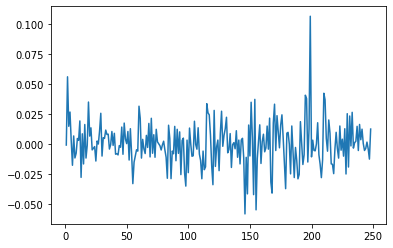

In [108]:
plt.plot(1 - y / x)

In [109]:
z = 1 - y / x
n = 0
l = 0
for c in z:
    if c == c:
        l += 1
        n = n + c
n / l

0.0002233782781238518

In [ ]:
Y = 0.4823*tnf[249,1] - 0.3777*ϵ

## Fourier Analysis

Finally for a spectral analysis?

### Plotting ARIMA Model Samples for ARIMA(0, 1, 1)

I will now track the \"change of the change ($\Delta^2)$\", using an ARIMA model for the inflation of Treasury securities using the markov chains montecarlo (MCMC) method for simulating  the change of inflation rate changes for upto 10,000 iterations.

In [ ]:
@model ARIMA010(x) = begin
    T = length(x)
    μ ~ Uniform(-10, 10)
    ϕ ~ Uniform(-1, 1)
    for t in 3:T
        val = x[t-1]                  # ARIMA(0,1,0) portion"
        x[t] ~ Normal(val, 1)
    end
end

@model ARIMA110(x) = begin
    T = length(x)
    μ ~ Uniform(-10, 10)
    ϕ ~ Uniform(-1, 1)
    for t in 3:T
        val = μ +                      # Drift term"
              x[t-1] +                 # ARIMA(0,1,0) portion"
              ϕ * (x[t-1] - x[t-2])    # ARIMA(1,0,0) portion"
        x[t] ~ Normal(val, 1)
    end
end

@model ARIMA011(x) = begin
    T = length(x)
    # Set up error vector.
    ϵ = Vector(undef, T)
    x_hat = Vector(undef, T)
    θ ~ Uniform(-5, 5)
    # Treat the first x_hat as a parameter to estimate.
    x_hat[1] ~ Normal(0, 1)
    ϵ[1] = x[1] - x_hat[1]
    for t in 2:T
        # Predicted value for x.
        x_hat[t] = x[t-1] - θ * ϵ[t-1]
        # Calculate observed error.
        ϵ[t] = x[t] - x_hat[t]
        # Observe likelihood.
        x[t] ~ Normal(x_hat[t], 1)
    end
end

Employing a Markov Chain Montecarlo method to test the models I derived using **statespace modeling**.

## Plotting ARIMA Model Samples Using the Markov Chain Montecarlo (MCMC) Method

### Plotting ARIMA Model Samples for ARIMA(1, 1, 1)

Below is a series of plots containing Summary Statistics for $0-10,000$ runs of the **markov chain montecarlo or MCMC** (above) and the quantiles (below). The graphics on the left measures the **stability of inflation data points** for quantiles running from $-\sigma$ to $\sigma$, and the graphics on the right of the $4 \times 4$ grid measures the density (notice how it is standard normal for Summary Statistics of the differenced inflation points), with quantiles having a uniform distribution, as per the model.

### Plotting ARIMA Model Samples for ARIMA(0, 1, 1)

Below is a series of plots containing Summary Statistics for $0-10,000$ runs of the **markov chain montecarlo or MCMC** (above) and the quantiles (below). The graphics on the left measures the **stability of inflation data points** for quantiles running from $-\sigma$ to $\sigma$, and the graphics on the right of the $4 \times 4$ grid measures the density (notice how it is standard normal for Summary Statistics of the differenced inflation points), with quantiles having a uniform distribution, as per the model.

### Plotting ARIMA Model Samples for ARIMA(0, 1, 3)

Below is a series of plots containing Summary Statistics for $0-10,000$ runs of the **markov chain montecarlo or MCMC** (above) and the quantiles (below). The graphics on the left measures the **stability of inflation data points** for quantiles running from $-\sigma$ to $\sigma$, and the graphics on the right of the $4 \times 4$ grid measures the density (notice how it is standard normal for Summary Statistics of the differenced inflation points), with quantiles having a uniform distribution, as per the model.

### Plotting ARIMA Model Samples for ARIMA(3, 1, 1)

Below is a series of plots containing Summary Statistics for $0-10,000$ runs of the **markov chain montecarlo or MCMC** (above) and the quantiles (below). The graphics on the left measures the **stability of inflation data points** for quantiles running from $-\sigma$ to $\sigma$, and the graphics on the right of the $4 \times 4$ grid measures the density (notice how it is standard normal for Summary Statistics of the differenced inflation points), with quantiles having a uniform distribution, as per the model.

### Plotting ARIMA Model Samples for ARIMA(2, 1, 3)

Below is a plot of Summary Statistics for $0-10,000$ runs of the **markov chain montecarlo or MCMC** (above) and the quantiles (below). The graphics on the left measures the **stability of inflation data points** for quantiles running from $-\sigma$ to $\sigma$, and the graphics on the right of the $4 \times 4$ grid measures the density (notice how it is standard normal for Summary Statistics of the differenced inflation points), with quantiles having a uniform distribution, as per the model.

chain_ARIMA213 = [sample(ARIMA213(s_train[:, C]), NUTS(200, 0.65), 10000) for C in 1:5]